In [1]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
metadata_species_df = pd.read_csv('mapping_file_taxonomy.csv')

# Convert the dates from string to datetime
metadata_species_df['Sample date'] = pd.to_datetime(metadata_species_df['Sample date'])

# Filter to grain yeild measurement date
metadata_species_df = metadata_species_df[metadata_species_df['Sample date'] == '2021-09-23']

print(metadata_species_df.shape)
metadata_species_df.head()

(31, 2975)


,Unnamed: 0.1,Unnamed: 0,Sample name,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,...,Bacteria Macrococcus sp. IME1552,Bacteria Enterococcus wangshanyuanii,Bacteria Staphylococcus delphini,Bacteria Staphylococcus lutrae,Bacteria Staphylococcus agnetis,Bacteria Staphylococcus chromogenes,Bacteria Staphylococcus kloosii,Bacteria Staphylococcus caprae,Bacteria Macrococcus brunensis,Bacteria Citrobacter sp. TBCP-5362
135,137,137,180,2021-09-23,2S,2S,111.0,Low,High,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,138,138,92,2021-09-23,2N,2N,111.0,Low,High,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,139,139,68,2021-09-23,32N,32N,311.0,Low,High,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,140,140,186,2021-09-23,3S,3S,115.0,Optimal,High,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,141,141,85,2021-09-23,3N,3N,115.0,Optimal,High,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
cols_to_exclude = [col for col in metadata_species_df.columns 
                   if ('Bacteria' in col or 'Fungi' in col) 
                   and col not in ['Bacteria Nitrosospira lacus', 'Bacteria Sphingomonas sediminicola']]

metadata_species_df_filtered = metadata_species_df.drop(columns=cols_to_exclude)
metadata_species_df_filtered.to_csv('data_for_adam.csv')
metadata_species_df_filtered.head()

,Unnamed: 0.1,Unnamed: 0,Sample name,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,...,qPCR_FW,qPCR_DW_log,qPCR_FW_log,GWC,Stems,Leaves,Shoots,Grain 0% MC,Bacteria Nitrosospira lacus,Bacteria Sphingomonas sediminicola
135,137,137,180,2021-09-23,2S,2S,111.0,Low,High,1,...,7.796367e+08,20.368120,20.474339,0.100772,246.927071,135.0,NaN,581.241,7.897440e+05,3.008438e+06
136,138,138,92,2021-09-23,2N,2N,111.0,Low,High,1,...,2.877475e+09,21.673961,21.780179,0.100772,246.927071,135.0,NaN,581.241,0.000000e+00,2.734941e+07
137,139,139,68,2021-09-23,32N,32N,311.0,Low,High,3,...,1.894250e+09,21.214641,21.362089,0.137092,352.801499,148.0,NaN,581.860,0.000000e+00,0.000000e+00
138,140,140,186,2021-09-23,3S,3S,115.0,Optimal,High,1,...,1.325819e+09,20.910279,21.005296,0.090642,336.572047,158.0,NaN,846.204,2.970215e+06,7.099536e+06
139,141,141,85,2021-09-23,3N,3N,115.0,Optimal,High,1,...,3.304077e+09,21.823406,21.918423,0.090642,336.572047,158.0,NaN,846.204,9.366697e+06,1.158437e+07


In [17]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [10]:
metadata_species_df_subset = metadata_species_df[metadata_species_df['Sample date'] == '2021-09-23']

X = metadata_species_df[['N trt target', 'Water trt target']]
y = metadata_species_df['Grain 0% MC']

param_grid = {
    'n_estimators': [10, 50],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, None]
}

# Initialize a zeros array of the same length as the features to store cumulative importances
cumulative_importances = np.zeros(X.shape[1])
r2_scores = []  # List to hold R2 values

n_splits = 25
for seed in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_

    # Predict using the best model
    predictions = best_rf.predict(X_test)

    # Calculate and store the R2 score
    r2 = r2_score(y_test, predictions)
    r2_scores.append(r2)
    
    # Add current importances to the cumulative importances
    cumulative_importances += best_rf.feature_importances_

# Compute the average importances and R2 score
average_importances = cumulative_importances / n_splits
average_r2 = np.mean(r2_scores)

# Create a DataFrame to visualize the average importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Average Importance': average_importances
})

# Sort the DataFrame by average importance values
features_df = features_df.sort_values(by='Average Importance', ascending=False)

# Display the results
print(f"Average R2 Score over {n_splits} splits: {average_r2:.3f}")
print(features_df)

Average R2 Score over 25 splits: 0.698
            Feature  Average Importance
1  Water trt target            0.686414
0      N trt target            0.313586


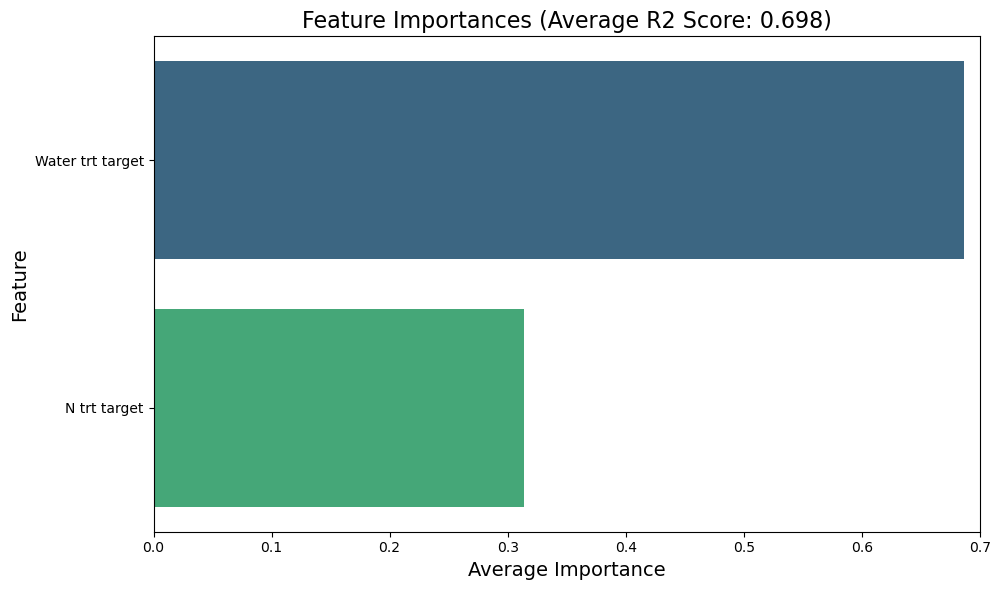

In [13]:
# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Importance', y='Feature', data=features_df, palette='viridis')
plt.title(f'Feature Importances (Average R2 Score: {average_r2:.3f})', fontsize=16)
plt.xlabel('Average Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.xlim(0,0.7)
plt.show()

In [18]:
X = metadata_species_df_subset[['N trt target', 'Water trt target', 'Bacteria Nitrosospira lacus', 'Bacteria Sphingomonas sediminicola']]
y = metadata_species_df_subset['Grain 0% MC']

param_grid = {
    'n_estimators': [10, 50],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, None]
}

# Initialize a zeros array of the same length as the features to store cumulative importances
cumulative_importances = np.zeros(X.shape[1])
r2_scores = []  # List to hold R2 values

n_splits = 25
for seed in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_

    # Predict using the best model
    predictions = best_rf.predict(X_test)

    # Calculate and store the R2 score
    r2 = r2_score(y_test, predictions)
    r2_scores.append(r2)
    
    # Add current importances to the cumulative importances
    cumulative_importances += best_rf.feature_importances_

# Compute the average importances and R2 score
average_importances = cumulative_importances / n_splits
average_r2 = np.mean(r2_scores)

# Create a DataFrame to visualize the average importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Average Importance': average_importances
})

# Sort the DataFrame by average importance values
features_df = features_df.sort_values(by='Average Importance', ascending=False)
features_df['Feature'] = features_df['Feature'].replace({'Water trt target': 'Water treatment', 'N trt target':'Nitrogen treatment'}).str.replace('Bacteria_', '').str.replace('_', ' ')
# Display the results
print(f"Average R2 Score over {n_splits} splits: {average_r2:.3f}")
print(features_df)

Average R2 Score over 25 splits: 0.695
                              Feature  Average Importance
1                     Water treatment            0.484442
2         Bacteria Nitrosospira lacus            0.192543
3  Bacteria Sphingomonas sediminicola            0.170368
0                  Nitrogen treatment            0.152647


In [21]:
importance_Bacteria_Nitrosospira_lacus = features_df.loc[features_df['Feature'] == 'Bacteria Nitrosospira lacus', 'Average Importance'].values[0]
importance_Bacteria_Sphingomonas_sediminicola = features_df.loc[features_df['Feature'] == 'Bacteria Sphingomonas sediminicola', 'Average Importance'].values[0]

# Total variation in maize yield predicted by the two bacteria
variation_Bacteria_Nitrosospira_lacus = average_r2 * importance_Bacteria_Nitrosospira_lacus
variation_Bacteria_Sphingomonas_sediminicola = average_r2 * importance_Bacteria_Sphingomonas_sediminicola

print(f"Total variation in maize yield predicted by Nitrosospira lacus: {variation_Bacteria_Nitrosospira_lacus*100:.2f}")
print(f"Total variation in maize yield predicted by Sphingomonas sediminicola: {variation_Bacteria_Sphingomonas_sediminicola*100:.2f}")

Total variation in maize yield predicted by Nitrosospira lacus: 13.38
Total variation in maize yield predicted by Sphingomonas sediminicola: 11.84


(0.0, 0.7)

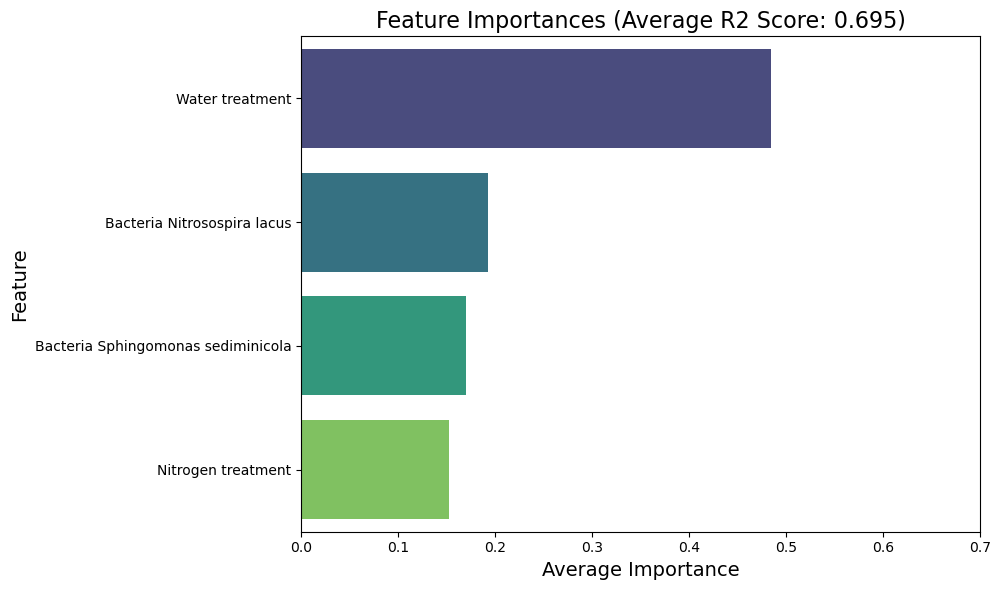

In [22]:
# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))

sns.barplot(x='Average Importance', y='Feature', data=features_df, palette='viridis')
plt.title(f'Feature Importances (Average R2 Score: {average_r2:.3f})', fontsize=16)
plt.xlabel('Average Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.xlim(0,0.7)
# plt.savefig('../../Bacterial manuscript/Figures/feature_importances.jpg', bbox_inches = 'tight', dpi = 300)

In [24]:
from sklearn.inspection import partial_dependence
from scipy.interpolate import interp1d

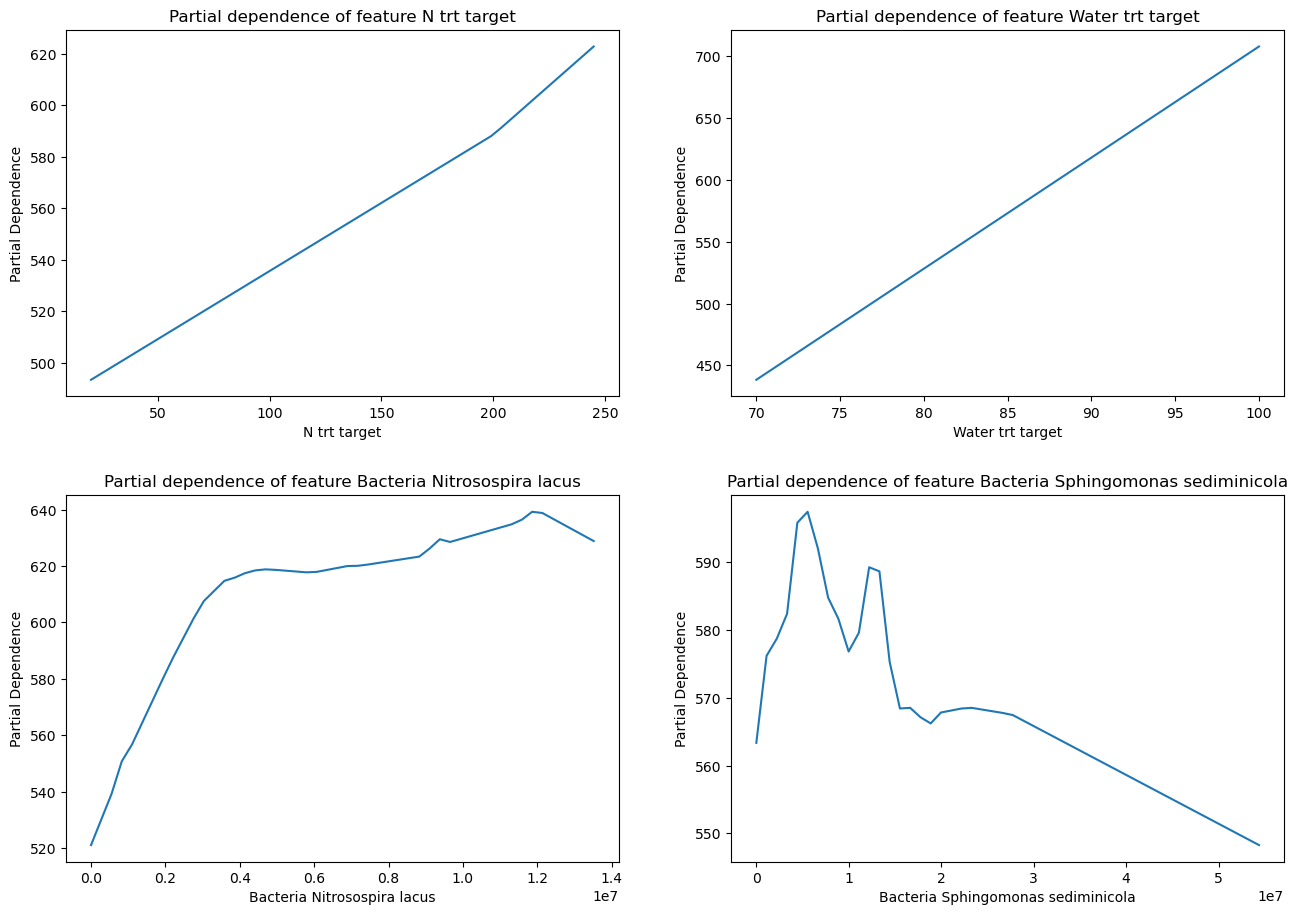

In [25]:
features = ['N trt target', 'Water trt target', 'Bacteria Nitrosospira lacus', 'Bacteria Sphingomonas sediminicola']

splits = 25
grid_size = 50
accumulated_pdp = [np.zeros(grid_size) for _ in features]
grid_ranges = [np.linspace(X[feature].min(), X[feature].max(), grid_size) for feature in features]

for _ in range(splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    best_rf = grid_search.best_estimator_

    # Calculate partial dependence
    for f_idx, feature in enumerate(features):
        results = partial_dependence(best_rf, X_train, features=[feature])
        pdp_values = results['average']
        pdp_grid = results['grid_values']
        
        # Interpolate to our consistent grid
        interp_func = interp1d(pdp_grid[0], pdp_values[0], kind='linear', fill_value="extrapolate")
        interp_values = interp_func(grid_ranges[f_idx])
        
        accumulated_pdp[f_idx] += interp_values

# Average the results
for f_idx in range(len(features)):
    accumulated_pdp[f_idx] /= splits

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout(pad=5.0)

for f_idx, feature in enumerate(features):
    row = f_idx // 2
    col = f_idx % 2
    axs[row, col].plot(grid_ranges[f_idx], accumulated_pdp[f_idx])
    axs[row, col].set_title(f"Partial dependence of feature {feature}")
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Partial Dependence')

plt.show()